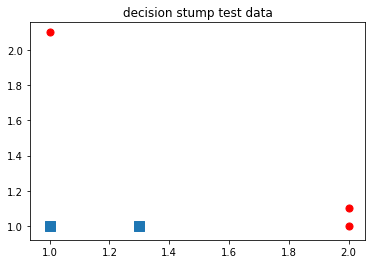

In [1]:
#adaptive boosting:是一种集成方法，通过组合多个弱分类器的分类结果，进行加权求和的分类结果

import numpy as np
import matplotlib.pyplot as plt

def loadSimpData():
    datMat = np.matrix(
        [[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

datMat,classLabels = loadSimpData()

#绘制一下

xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []
markers =[]
colors =[]

for i in range(len(classLabels)):
    if classLabels[i]==1.0:
        xcord1.append(datMat[i,0]), ycord1.append(datMat[i,1])
    else:
        xcord0.append(datMat[i,0]), ycord0.append(datMat[i,1])
fig = plt.figure()
ax = fig.add_subplot(111)       
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('decision stump test data')
plt.show()

In [12]:
#分类函数
#(数据集，特征，阈值，阈值判定方法)
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = np.ones((np.shape(dataMatrix)[0],1)) #这里分为1和-1两个类别
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
    
#构建单层决策树（decision stump决策树桩）
#(数据集，分类标签y,样本数据的权重向量D)
def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClasEst = np.mat(np.zeros((m,1)))
    minError = np.inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions遍历所有特征
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax-rangeMin)/numSteps #针对连续数值型的特征，通过步长来选择合适的分界值
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than切换大于和小于的判断
                threshVal = (rangeMin + float(j) * stepSize) #可以看到，j=11，会超出范围
                #这里调用预测分类函数
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D加权错误率
                #print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
                if weightedError < minError: #选择最佳的单层决策树，最小的加权错误率（而不是错误率）
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst



In [3]:
D = np.mat(np.ones((5,1)) / 5.0) #所有向量之和=1
bestStump,minError,bestClasEst = buildStump(datMat,classLabels,D)


split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50, thresh ineq

In [6]:
print bestStump
print minError
print bestClasEst

{'dim': 0, 'ineq': 'lt', 'thresh': 1.3}
[[ 0.2]]
[[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


In [30]:
#单层决策树的训练过程 ：p117的公式
#首先，基于样本的权重向量D（开始每个样本都是相同值）,
# 然后训练一个弱分类器（单层决策树），并且得到分类的错误率（加权）和该分类器的权重值alpha
#接着迭代：在同一个数据集中，调整D（分对的，权重降低，分错的，权重提高），再训练得到分类器\错误率\alpha
#最后得到所有分类器的加权结果:sum(alpha[i]*y[i])
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = [] #记录每次迭代得到的弱分类器[{bestStump1},{bestStump2}...]
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)   #init D to all equal
    aggClassEst = np.mat(np.zeros((m,1))) #记录每个样本数据的类别估计累计值(加权累加)
    errorRate = 0.0
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print "D:",D.T
        #下面公式见P117-118
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print "classEst: ",classEst.T
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = np.multiply(D,np.exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        #print "aggClassEst: ",aggClassEst.T
        #可以通过变量aggClassEst的符号，来判断类别：sign(sum(alpha[i]*y[i]))函数
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1))) 
        errorRate = aggErrors.sum()/m #分错的样本数
        #print "total error: ",errorRate
        if errorRate == 0.0: 
            break
    return weakClassArr,aggClassEst,errorRate

In [14]:
weakClassArr,aggClassEst,errorRate = adaBoostTrainDS(datMat,classLabels,9)


D: [[ 0.2  0.2  0.2  0.2  0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2
D: [[ 0.5    0.125  0.125  0.125  0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2
D: [[ 0.28571429  0.07142857  0.07142857  0.07142857  0.5       ]]
classEst:  [[ 1.  1.  1.  1.  1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0


In [15]:
print weakClassArr
#可以看出，训练了3个弱分类器

[{'dim': 0, 'ineq': 'lt', 'thresh': 1.3, 'alpha': 0.6931471805599453}, {'dim': 1, 'ineq': 'lt', 'thresh': 1.0, 'alpha': 0.9729550745276565}, {'dim': 0, 'ineq': 'lt', 'thresh': 0.90000000000000002, 'alpha': 0.8958797346140273}]


In [25]:
#adaBoost分类函数
#（数据集，训练好的多个分类器）
#利用训练好的多个弱分类器，进行加权分类
def adaClassify(datToClass,classifierArr):
    dataMatrix = np.mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1))) 
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst #分类估计值的加权累加和
        #print aggClassEst
    return np.sign(aggClassEst)


In [17]:
pred = adaClassify([[5,5],[0,0]],weakClassArr)
print pred

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]
[[ 1.]
 [-1.]]


In [18]:
#用一个难数据集，测试一下

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat


In [23]:
#训练
trainArr,trainLabel = loadDataSet('adaBoost/horseColicTraining2.txt')
weakClassArr1,aggClassEst1,errorRate1 = adaBoostTrainDS(trainArr,trainLabel,10)



total error:  0.284280936455
total error:  0.284280936455
total error:  0.247491638796
total error:  0.247491638796
total error:  0.254180602007


total error:  0.240802675585
total error:  0.240802675585
total error:  0.220735785953
total error:  0.247491638796


total error:  0.230769230769


In [28]:
#测试
testArr,testLabel = loadDataSet('adaBoost/horseColicTest2.txt')
pred1 = adaClassify(testArr,weakClassArr1)
testError = np.mean(pred1.A.ravel()!=np.array(testLabel))
print testError
print 'should be 16/67',16.0/67

0.238805970149
should be 16/67 0.238805970149


In [33]:
#来看看分类器的个数的增加，算法的训练和测试效果
#这里稍微改了一下adaBoostTrainDS(),最后一行多一个返回errorRate,注释掉一些输出
for iters in [1,10,30,50,100]:
    weakClassArr,aggClassEst,errorRate = adaBoostTrainDS(trainArr,trainLabel,iters)
    pred = adaClassify(testArr,weakClassArr1)
    testError = np.mean(pred.A.ravel()!=np.array(testLabel))
    print 'at iters ',iters,'train error=',errorRate,'test error=',testError

at iters  1 train error= 0.284280936455 test error= 0.238805970149


at iters  10 train error= 0.230769230769 test error= 0.238805970149


at iters  30 train error= 0.217391304348 test error= 0.238805970149


at iters  50 train error= 0.1872909699 test error= 0.238805970149


at iters  100 train error= 0.190635451505 test error= 0.238805970149
